In [1]:
import gym
import final_proj
import numpy as np


from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline
# Hugging Face Hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

env_id = 'final_proj/RLDocter_v0'
eval_env = gym.make(env_id)
env = gym.make(env_id)

couldn't import doomish


In [2]:
s_size = env.observation_space.shape[0]
a_size = env.action_space.n
print(s_size)
print(a_size)

1
2


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        # Code Here
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, a_size)
        self.fc4 = nn.Linear(a_size, a_size)

    def forward(self, x):
        # Define the forward process here (with ReLU activation for the first 2 layers)
        # x -> fc1 -> ReLU -> fc2 -> ReLU -> fc3
        # Code Here
        #print("first", x)
        x = self.fc1(x)
        #print("second", x)
        x = F.relu(x)

        x = F.relu(self.fc2(x))
        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        # We output the softmax
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        probs = self.forward(state).cpu()

        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [26]:
class myRNN(nn.Module):
    def __init__(self, batch_size=1, n_inputs=1, n_neurons = 128, n_outputs = 2, num_layers = 1, dropout_rate = 0.5):
        super(myRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(self.dropout_rate)
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)
        self.rnns = nn.ModuleList([nn.RNN(self.n_inputs, self.n_neurons) for _ in range(self.num_layers)])
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        self.layer_norm = nn.LayerNorm(n_inputs)

        self.bn = nn.BatchNorm1d(1)
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons)).to(device)

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.view(1, self.batch_size, 1)


        self.batch_size = X.size(1)
        X = self.layer_norm(X)
        self.hidden = self.init_hidden()

        # lstm_out => n_steps, batch_size, n_neurons (hidden states for each time step)
        # self.hidden => 1, batch_size, n_neurons (final state from each lstm_out)
        #lstm_out, self.hidden = self.basic_rnn(X, self.hidden)
        for rnn in self.rnns:
            lstm_out, self.hidden = rnn(X, self.hidden)
        out = self.FC(self.hidden)

        return F.softmax(out.view(-1, self.n_outputs), dim=1) # batch_size X n_output
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [27]:
from torch.autograd import Variable
class LSTM(nn.Module):

    def __init__(self, batch_size=1, num_classes=2, input_size=1, hidden_size=4, num_layers=1):
        super(LSTM, self).__init__()

        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = 1

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(self.batch_size, 1, 1)
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to("cuda:0")

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).to("cuda:0")

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return F.softmax(out, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
print(device)

cuda:0


In [30]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):

        saved_log_probs = []
        rewards = []
        state = env.reset() # Code Here: reset the environment
        # Line 4 of pseudocode
        for t in range(max_t):

            action, log_prob = policy.act(state)# Code Here: get the action
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)# Code Here: take an env step
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        ## We compute this starting from the last timestep to the first, to avoid redundant computations

        ## appendleft() function of queues appends to the position 0
        ## We use deque instead of lists to reduce the time complexity

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)

            returns.appendleft(rewards[t] + gamma * disc_return_t) # Code Here: complete here

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        #print("here", returns)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [31]:
docter_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 10000,
    "n_evaluation_episodes": 10,
    "max_t": 10000,
    "gamma": 0.99,
    "lr": 1e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [32]:
# Create policy and place it to the device
torch.manual_seed(50) # Don't change this
docter_policy_mlp = Policy(docter_hyperparameters["state_space"], docter_hyperparameters["action_space"], docter_hyperparameters["h_size"]).to(device)
docter_optimizer_mlp = optim.Adam(docter_policy_mlp.parameters(), lr=docter_hyperparameters["lr"])

In [33]:
docter_policy_RNN = myRNN().to(device)
docter_optimizer_RNN = optim.Adam(docter_policy_RNN.parameters(), lr=docter_hyperparameters["lr"])

In [34]:
docter_policy_LSTM = LSTM().to(device)
docter_optimizer_LSTM = optim.Adam(docter_policy_LSTM.parameters(), lr=docter_hyperparameters["lr"])

In [35]:
scores_mlp = reinforce(docter_policy_mlp,
                   docter_optimizer_mlp,
                   docter_hyperparameters["n_training_episodes"],
                   docter_hyperparameters["max_t"],
                   docter_hyperparameters["gamma"],
                   1000)


Episode 1000	Average Score: 2.95
Episode 2000	Average Score: 3.09
Episode 3000	Average Score: 3.14
Episode 4000	Average Score: 3.07
Episode 5000	Average Score: 3.27
Episode 6000	Average Score: 3.49
Episode 7000	Average Score: 3.75
Episode 8000	Average Score: 3.70
Episode 9000	Average Score: 4.06
Episode 10000	Average Score: 4.20


In [36]:

scores_RNN = reinforce(docter_policy_RNN,
                   docter_optimizer_RNN,
                   1000,
                   docter_hyperparameters["max_t"],
                   docter_hyperparameters["gamma"],
                   100)

Episode 100	Average Score: 3.16
Episode 200	Average Score: 3.42
Episode 300	Average Score: 3.71
Episode 400	Average Score: 3.92
Episode 500	Average Score: 4.82
Episode 600	Average Score: 5.63
Episode 700	Average Score: 7.84
Episode 800	Average Score: 13.36
Episode 900	Average Score: 22.55
Episode 1000	Average Score: 38.08


In [37]:
scores_LSTM = reinforce(docter_policy_LSTM,
                   docter_optimizer_LSTM,
                   10000,
                   docter_hyperparameters["max_t"],
                   docter_hyperparameters["gamma"],
                   1000)

Episode 1000	Average Score: 2.92
Episode 2000	Average Score: 3.04
Episode 3000	Average Score: 3.17
Episode 4000	Average Score: 3.42
Episode 5000	Average Score: 4.18
Episode 6000	Average Score: 4.23
Episode 7000	Average Score: 4.57
Episode 8000	Average Score: 5.50
Episode 9000	Average Score: 5.67
Episode 10000	Average Score: 6.82


In [38]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, _ = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [39]:
#Eval MLP
eval_env = gym.make(env_id)
evaluate_agent(eval_env,
               docter_hyperparameters["max_t"],
               docter_hyperparameters["n_evaluation_episodes"],
               docter_policy_mlp)

d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. 

(4.379999999999999, 1.1728597529116593)

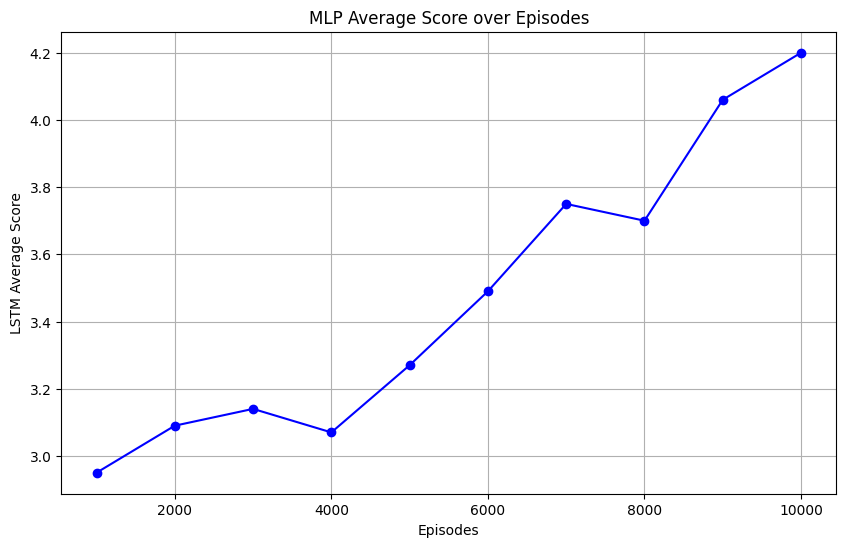

In [47]:
episodes_2 = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
average_scores_2 = [2.95, 3.09, 3.14, 3.07, 3.27, 3.49, 3.75, 3.70, 4.06, 4.20]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes_2, average_scores_2, marker='o', linestyle='-', color='b')
plt.title('MLP Average Score over Episodes')
plt.xlabel('Episodes')
plt.ylabel('LSTM Average Score')
plt.grid(True)
plt.show()

In [48]:
#Eval LSTM
eval_env = gym.make(env_id)
evaluate_agent(eval_env,
               docter_hyperparameters["max_t"],
               docter_hyperparameters["n_evaluation_episodes"],
               docter_policy_LSTM)

d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
d:\联想实习\abc\lib\site-packages\gym\utils\passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. 

(6.880000000000001, 3.237221030451894)

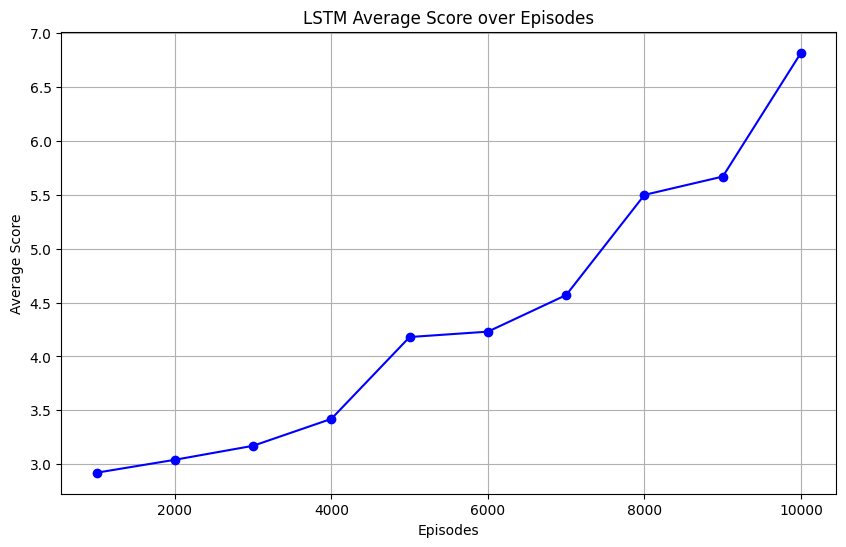

In [53]:
episodes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
average_scores = [2.92, 3.04, 3.17, 3.42, 4.18, 4.23, 4.57, 5.50, 5.67, 6.82]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, average_scores, marker='o', linestyle='-', color='b')
plt.title('LSTM Average Score over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

In [50]:
#Eval RNN
eval_env = gym.make(env_id)
evaluate_agent(eval_env,
               docter_hyperparameters["max_t"],
               docter_hyperparameters["n_evaluation_episodes"],
               docter_policy_RNN)

(46.29999999999991, 18.195274111702602)

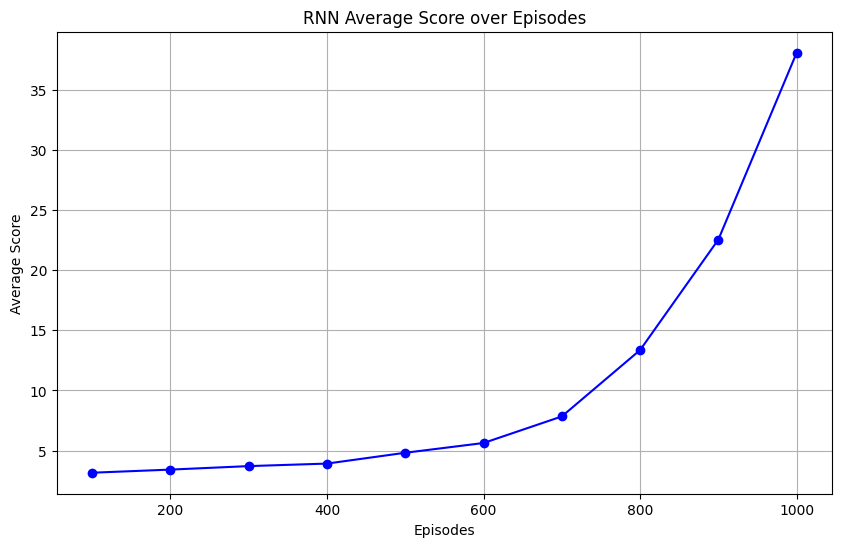

In [51]:
episodes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
average_scores = [3.16, 3.42, 3.71, 3.92, 4.82, 5.63, 7.84, 13.36, 22.55, 38.08]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, average_scores, marker='o', linestyle='-', color='b')
plt.title('RNN Average Score over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.grid(True)
plt.show()

In [52]:
#save the models
torch.save(docter_policy_RNN, "rnn_model.pth")
torch.save(docter_policy_mlp, "mlp_model.pth")
torch.save(docter_policy_LSTM, "lstm_model.pth")